2024-05-19 22:52:30,745 - INFO - Created directory: Dataset_Split\train\Ace
2024-05-19 22:52:30,746 - INFO - Created directory: Dataset_Split\train\Akainu
2024-05-19 22:52:30,747 - INFO - Created directory: Dataset_Split\train\Brook
2024-05-19 22:52:30,747 - INFO - Created directory: Dataset_Split\train\Chopper
2024-05-19 22:52:30,748 - INFO - Created directory: Dataset_Split\train\Crocodile
2024-05-19 22:52:30,748 - INFO - Created directory: Dataset_Split\train\Franky
2024-05-19 22:52:30,749 - INFO - Created directory: Dataset_Split\train\Jinbei
2024-05-19 22:52:30,749 - INFO - Created directory: Dataset_Split\train\Kurohige
2024-05-19 22:52:30,750 - INFO - Created directory: Dataset_Split\train\Law
2024-05-19 22:52:30,750 - INFO - Created directory: Dataset_Split\train\Luffy
2024-05-19 22:52:30,751 - INFO - Created directory: Dataset_Split\train\Mihawk
2024-05-19 22:52:30,752 - INFO - Created directory: Dataset_Split\train\Nami
2024-05-19 22:52:30,752 - INFO - Created directory: Data

Found 8204 images belonging to 18 classes.


2024-05-19 22:53:03,986 - INFO - Augmented image 0 for class Sanji
2024-05-19 22:53:03,986 - INFO - Augmented image 1 for class Akainu
2024-05-19 22:53:03,987 - INFO - Augmented image 2 for class Brook
2024-05-19 22:53:03,987 - INFO - Augmented image 3 for class Luffy
2024-05-19 22:53:03,988 - INFO - Augmented image 4 for class Ace
2024-05-19 22:53:03,988 - INFO - Augmented image 5 for class Mihawk
2024-05-19 22:53:03,988 - INFO - Augmented image 6 for class Akainu
2024-05-19 22:53:03,989 - INFO - Augmented image 7 for class Ace
2024-05-19 22:53:03,989 - INFO - Augmented image 8 for class Jinbei
2024-05-19 22:53:03,989 - INFO - Augmented image 9 for class Luffy
2024-05-19 22:53:03,990 - INFO - Augmented image 10 for class Shanks
2024-05-19 22:53:03,990 - INFO - Augmented image 11 for class Akainu
2024-05-19 22:53:03,990 - INFO - Augmented image 12 for class Akainu
2024-05-19 22:53:03,991 - INFO - Augmented image 13 for class Chopper
2024-05-19 22:53:03,991 - INFO - Augmented image 14 f

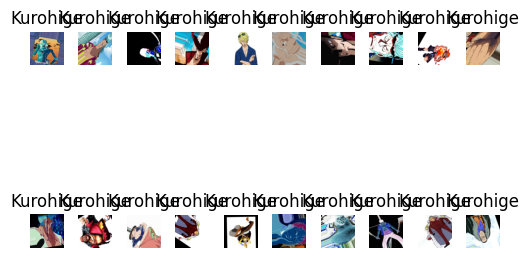

In [6]:
import os
import shutil
import numpy as np
import logging
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_directories(base_dir, categories):
    """
    Create directories for training, testing, and validation datasets.

    Parameters:
    - base_dir (str): The base directory where the train, test, and validation directories will be created.
    - categories (list): List of category names (sub-directory names) to create inside each of train, test, and validation directories.
    """
    for subset in ['train', 'test', 'validation']:
        for category in categories:
            dir_path = os.path.join(base_dir, subset, category)
            os.makedirs(dir_path, exist_ok=True)
            logging.info(f'Created directory: {dir_path}')

def copy_images(source_dir, images, dest_dir):
    """
    Copy images from source directory to destination directory.

    Parameters:
    - source_dir (str): The directory containing the source images.
    - images (list): List of image filenames to copy.
    - dest_dir (str): The destination directory where images will be copied.
    """
    for image in images:
        shutil.copy(os.path.join(source_dir, image), os.path.join(dest_dir, image))
        logging.info(f'Copied {image} to {dest_dir}')

def split_dataset(source_dir, base_dir, split_ratios=(0.7, 0.15, 0.15)):
    """
    Split the dataset into training, testing, and validation sets.

    Parameters:
    - source_dir (str): The source directory containing subdirectories of images for each category.
    - base_dir (str): The base directory where the split datasets will be stored.
    - split_ratios (tuple): A tuple containing the ratios for splitting the dataset into train, test, and validation sets.

    Raises:
    - ValueError: If the split ratios do not sum to 1.
    """
    if sum(split_ratios) != 1:
        raise ValueError("Split ratios must sum to 1. Provided ratios sum to {:.2f}".format(sum(split_ratios)))
    
    categories = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
    create_directories(base_dir, categories)

    for category in categories:
        category_path = os.path.join(source_dir, category)
        images = os.listdir(category_path)
        np.random.shuffle(images)

        train_split = int(len(images) * split_ratios[0])
        test_split = int(len(images) * split_ratios[1])

        train_images = images[:train_split]
        test_images = images[train_split:train_split + test_split]
        validation_images = images[train_split + test_split:]

        copy_images(category_path, train_images, os.path.join(base_dir, 'train', category))
        copy_images(category_path, test_images, os.path.join(base_dir, 'test', category))
        copy_images(category_path, validation_images, os.path.join(base_dir, 'validation', category))
        
def preprocess_image(image_path):
    img = Image.open(image_path)
    if img.mode == 'P' and 'transparency' in img.info:
        img = img.convert('RGBA')
        img = img.convert('RGB')
    if img.mode == 'RGBA':
        img = img.convert('RGB')
    return img


def augment_train_dataset(train_path='Dataset_Split/train', augmented_path='augmented', width=150, height=150, batch_size=64):
    os.makedirs(augmented_path, exist_ok=True)  # Create augmented_path directory if it does not exist

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
    )

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(width, height),
        batch_size=batch_size,
        class_mode='categorical',
        save_to_dir=augmented_path,
        save_prefix='aug',
        save_format='png'
    )

    classes = train_generator.class_indices

    for i, (images, labels) in enumerate(train_generator):
        if i >= len(train_generator):
            break
        for j in range(len(images)):
            label_index = np.argmax(labels[j])
            label = [k for k, v in classes.items() if v == label_index][0]
            logging.info(f"Augmented image {i * batch_size + j} for class {label}")

    # Printing a sample of the images generated in the preprocessing
    num_imgs = min(images.shape[0], 20)
    fig, axarr = plt.subplots(2, 10, figsize=(5, 5))
    for i in range(num_imgs):
        row = i // 10
        col = i % 10
        axarr[row, col].imshow(images[i])
        axarr[row, col].set_title(label)
        axarr[row, col].axis('off')
    plt.tight_layout()
    plt.show()



def setup_and_split_dataset(source_dir='Data', base_dir='Dataset_Split', split_ratios=(0.7, 0.15, 0.15)):
    """
    Set up logging, define directories, and split the dataset.

    Parameters:
    - source_dir (str): The source directory containing subdirectories of images for each category.
    - base_dir (str): The base directory where the split datasets will be stored.
    - split_ratios (tuple): A tuple containing the ratios for splitting the dataset into train, test, and validation sets.
    """
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    try:
        split_dataset(source_dir, base_dir, split_ratios)
    except ValueError as e:
        logging.error(e)
        


if __name__ == "__main__":
    setup_and_split_dataset()
    augment_train_dataset()
    a = 1